In [13]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
from collections import OrderedDict
import seaborn as sns
import pandas as pd
import gzip
from scipy.signal import filtfilt, butter
import pickle

In [2]:
data_path = 'ssvep_dataset/'
subj_list = os.listdir(data_path)
records = {k: [] for k in subj_list}
for subj in subj_list:
    record_all = os.listdir(data_path+subj+'/')
    n = len(record_all)//4#number of records of a given subject
    for i in range(n):
        records[subj].append(record_all[i*4][:28])

In [3]:
#choose a subject and a record of that subject
chosen_subject_index = 11 #suject12
chosen_subject = subj_list[chosen_subject_index]
print("The chosen subject is",chosen_subject,". He has",len(records[chosen_subject]),"records")
session_index = 0 #the first session of the subject12
print("The chosen session was done on",records[chosen_subject][session_index][8:27])

The chosen subject is subject12 . He has 5 records
The chosen session was done on 2014.03.10-19.17.37


In [88]:
tmin=2
tmax=5
event_id = dict(resting=1, stim13=2, stim17=3, stim21=4)#define the events
freq_events={'resting':0,'stim13':13,'stim17':17,'stim21':21}
sfreq = 256
channels = np.array(['Oz','O1','O2','PO3','POz','PO7','PO8','PO4'])
names=['resting','stim13','stim21','stim17']

In [19]:
#loading data

fname = chosen_subject+'/'+records[chosen_subject][session_index]
with gzip.open(data_path + fname + '.pz', 'rb') as f:
    o = pickle.load(f, encoding='latin1')
raw_signal = o['raw_signal'].T
event_pos = o['event_pos'].reshape((o['event_pos'].shape[0]))
event_type = o['event_type'].reshape((o['event_type'].shape[0]))

In [24]:
raw_signal.shape

(8, 192224)

In [39]:
t= 0
while event_type[t] != 32779: #begining of first trial
    t+=1
start = event_pos[t]
print("The first tial begins at ", start/sfreq, "s ")

The first tial begins at  45.50390625 s 


## Extracting Covariance Matrices

For a given subject and a given session:
- Step 0 :  Let $X \in \mathbb{R}^{C \times M}$ the multichannel raw signal where $C=8$ is the number of electrods/channels and $M =192224$ is the total duration of the recording
- Step 1 : For each stimulus frequency $f \in \mathcal{F}:=\{13,17,21\}$, compute $X_f \in \mathbb{R}^{C \times M}$ where $X_f$=filtered($X,f$) the result of filtering $X$ with a pass_band filter concentrated on $f$
- Step 2 : concatenat all to get the extended signal $X_{ext} = [X_f \mbox{ for } f \in \mathcal{F}]^T$. So, $X_{ext} \in \mathbb{R}^{FC \times M}$ where $F=3$ and then $FC=24$
- Step 3 : keep only interesting time intervels corresponding to epochs to get $X_{ext}^{(i)}$ for $i \in [\![1,I]\!]$ where $I$ is the number of trials (Here $I=32$). So, $X_{ext}^{(i)} \in \mathbb{R}^{FC \times N}$ where $N$ is the length of a trial (Here, $N=f_s \times \Delta \mbox{epoch } = 256 \times 3 =768$). For each trial $i$, we know the associated class $k_i \in \{\mbox{resting,stim13,stim21,stim17}\}$

In [20]:
#The Butterworth filter : band-pass filter, flat in the passband , the passband is concentrated on 
def filter_bandpass(signal, fmin, fmax, fs, order=4, filttype='forward-backward'):
    nyq = 0.5 * fs
    low = fmin / nyq
    high = fmax / nyq
    b, a = butter(order, [low, high], btype='band')
    #filter tpe : forwaard-backward
    filtered = filtfilt(b, a, signal, axis=-1)  
    return filtered

In [129]:
?butter

In [22]:
frequencies = [13., 17., 21.]
freq_band = 0.1    
ext_signal = np.empty_like(raw_signal[0,:])    
for f in frequencies:
    ext_signal = np.vstack((ext_signal, filter_bandpass(raw_signal, f-freq_band, f+freq_band, fs=sfreq)))
ext_signal = ext_signal[1:,:]
ext_signal.shape

(24, 192224)

In [27]:
ext_trials = list()
for e, t in zip(event_type, event_pos):
    if e == 32779: # start of a trial
        start = t + tmin*sfreq
        stop  = t + tmax*sfreq
        ext_trials.append(ext_signal[:, start:stop])
ext_trials = np.array(ext_trials)
ext_trials = ext_trials - np.tile(ext_trials.mean(axis=2).reshape(ext_trials.shape[0], 
                            ext_trials.shape[1], 1), (1, 1, ext_trials.shape[2]))
ext_trials.shape

(32, 24, 768)

In [58]:
labels = []
for e in event_type:
    if e==33024:#resting
        labels.append(0)
    if e==33025:#stim13
        labels.append(1)
    if e==33026:#stim21
        labels.append(2)
    if e==33027:#stim17
        labels.append(3)
print(labels)
len(labels)

[0, 0, 0, 2, 3, 1, 2, 0, 1, 3, 1, 2, 0, 3, 2, 3, 1, 0, 3, 1, 2, 3, 0, 1, 2, 1, 3, 0, 2, 3, 2, 1]


32

Text(0.5, 0, 'Time (s)')

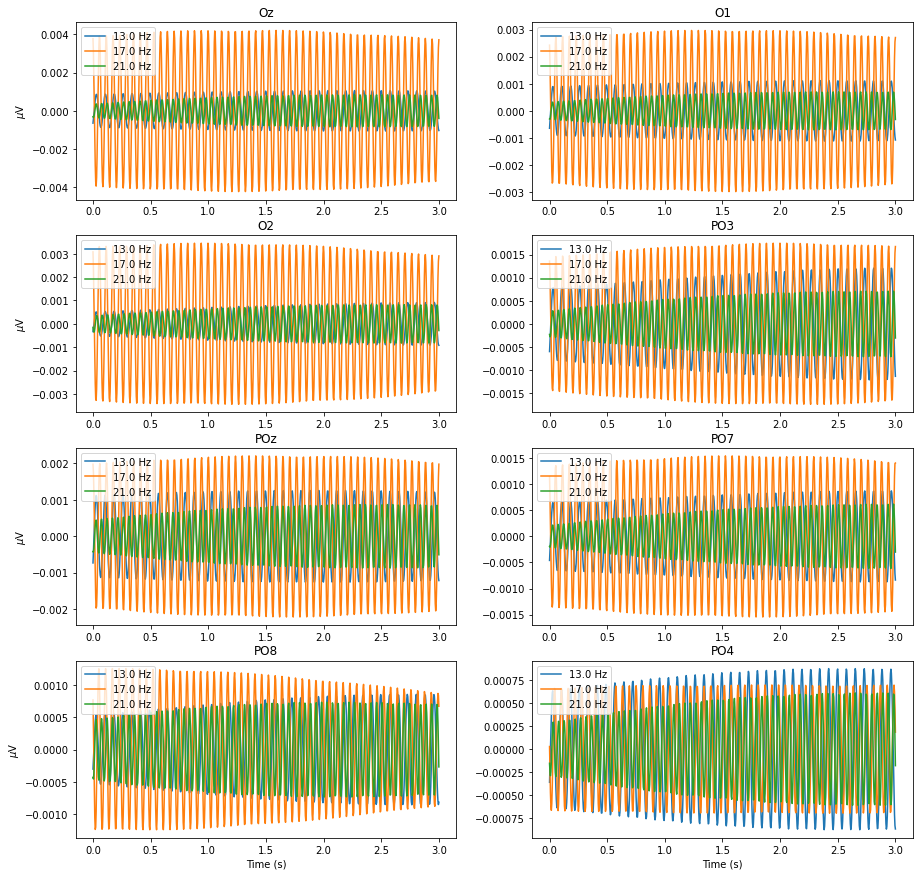

In [69]:
#visualisation of the extended signals of a given trial
trial  = 4
n_seconds = 3
time = np.linspace(0, n_seconds, n_seconds * sfreq).reshape((1, n_seconds * sfreq))
fig, axs = plt.subplots(4,2,figsize=(15,15))
axs =axs.flatten()
for i in range(8):
    axs[i].plot(time.T, ext_trials[trial, i, :].T, label=str(frequencies[0])+' Hz')
    axs[i].plot(time.T, ext_trials[trial, 8+i, :].T, label=str(frequencies[1])+' Hz')
    axs[i].plot(time.T, ext_trials[trial, 16+i, :].T, label=str(frequencies[2])+' Hz')
    if i%2==0:
        axs[i].set_ylabel("$\\mu$V")
    axs[i].set_title(channels[i])
    axs[i].legend(loc='upper left')
axs[i-1].set_xlabel('Time (s)')
axs[i].set_xlabel('Time (s)')

**Question:** Is it possible to extract epochs then filter then then stack them to get the extended trials?

**>> Answer:** NO ! Border Effects

In [130]:
events=[] #stock the starting time of an event and its type (only resting, stim13, stim21 and stim17)
for i in range(len(event_pos)):
    if event_type[i]==33024: #resting
        events.append([event_pos[i+1],1])
    if event_type[i]==33025: #stim13
        events.append([event_pos[i+1],2])
    if event_type[i]==33026: #stim21
        events.append([event_pos[i+1],3])
    if event_type[i]==33027: #stim17
        events.append([event_pos[i+1],4])

#extract epochs
epochs=[]
for i in range(len(events)):
    epochs.append(raw_signal[:, events[i][0]+sfreq*tmin:events[i][0]+sfreq*tmax]) 
epochs = np.asarray(epochs)
print("Epochs shape =",epochs.shape)



#filter epochs
filtered_epochs= [np.empty_like(epochs) for f in frequencies]

for k in range(len(frequencies)):
    for i in range(len(epochs)):
        f =frequencies[k]
        X= epochs[i,:,:]
        X = X * np.hanning(X.shape[-1])[None]
        filtered_epochs[k][i,:,:] = filter_bandpass(X, f-freq_band, f+freq_band, fs=sfreq)

extended = np.zeros((epochs.shape[0],epochs.shape[1],len(frequencies),epochs.shape[2]))
for f in range(len(frequencies)):
    for i in range(epochs.shape[0]): #32
        for j in range(extended.shape[1]): #24
            extended[i,j,f,:] = filtered_epochs[f][i,j,:]
extended =extended.reshape((epochs.shape[0],epochs.shape[1]*len(frequencies),epochs.shape[2]))
print("Extended trials shape", extended.shape)

Epochs shape = (32, 8, 768)
Extended trials shape (32, 24, 768)


Text(0.5, 0, 'Time (s)')

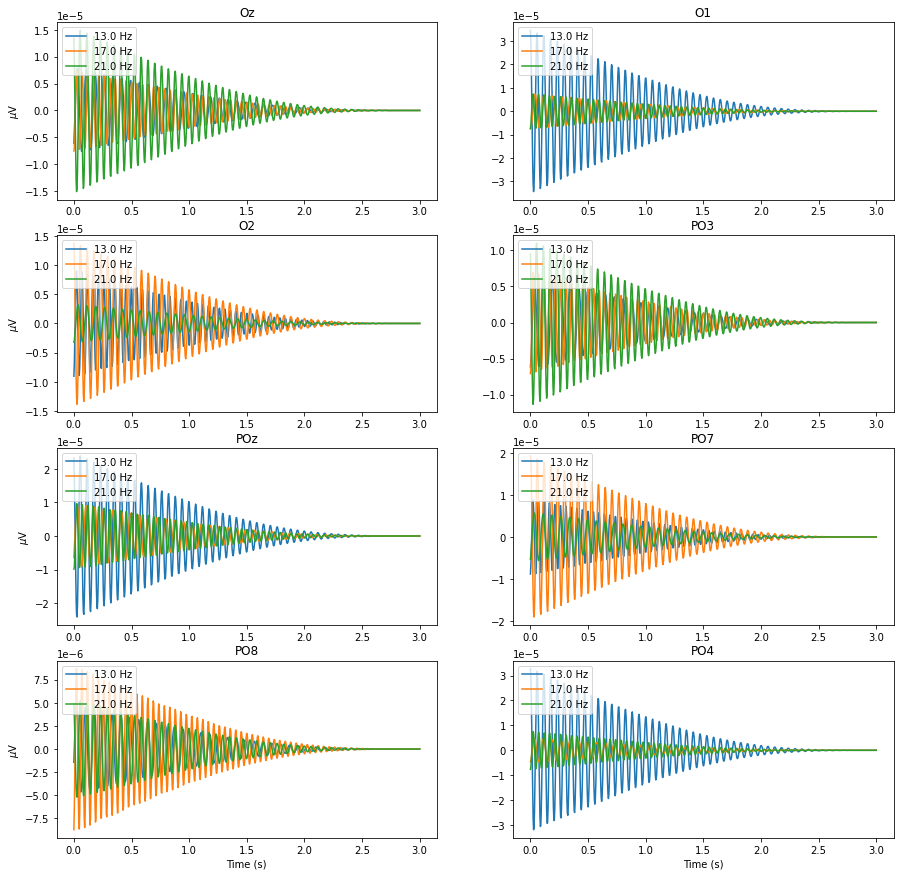

In [131]:
#visualisation of the extended signals of a given trial
trial  = 4
n_seconds = 3
time = np.linspace(0, n_seconds, n_seconds * sfreq).reshape((1, n_seconds * sfreq))
fig, axs = plt.subplots(4,2,figsize=(15,15))
axs =axs.flatten()
for i in range(8):
    axs[i].plot(time.T, extended[trial, i, :].T, label=str(frequencies[0])+' Hz')
    axs[i].plot(time.T, extended[trial, 8+i, :].T, label=str(frequencies[1])+' Hz')
    axs[i].plot(time.T, extended[trial, 16+i, :].T, label=str(frequencies[2])+' Hz')
    if i%2==0:
        axs[i].set_ylabel("$\\mu$V")
    axs[i].set_title(channels[i])
    axs[i].legend(loc='upper left')
axs[i-1].set_xlabel('Time (s)')
axs[i].set_xlabel('Time (s)')

## Spatial covariance estimation


We recall $\overline{x}^{(i)} = \frac{1}{N} \sum_{n=1}^N x_n^{(i)} = \frac{1}{N} X^{(i)} \ U $
where $U =[1,...,1]^T \in \mathbb{R}^N$.

The SCM is given by: 
\begin{equation}
    \begin{split}
        C_i & = \frac{1}{N-1} \sum_{n=1}^N (x_n^{(i)}-\overline{x})(x_n^{(i)}-\overline{x})^T \\
            & = \frac{1}{N-1} \left(\sum_{n=1}^N x_n^{(i)}x_n^{(i)T }- N \overline{x}\  \overline{x}^T \right)\\
            & = \frac{1}{N-1} \left(X^{(i)}X^{(i)T} - \frac{1}{N} (X^{(i)} \ U) (X^{(i)} \ U)^T \right)\\
            & = \frac{1}{N-1} X^{(i)} \left(I_N- \frac{1}{N} U \ U^T \right) X^{(i)T}
    \end{split}
\end{equation}

In [82]:
from pyriemann.estimation import Covariances

cov_ext_trials = Covariances(estimator='scm').transform(ext_trials)
cov_ext_trials.shape
#cov_ext_trials

(32, 24, 24)

In [86]:
#define scm without pyriemann and compare
cov = np.zeros((32,24,24))
N = ext_trials.shape[2] #768
print('N=',N)
U=np.ones((N,1))
for i in range(32):
    cov[i,:,:]= (1/(N-1))*ext_trials[i,:,:]@(np.eye(N)-(1/N)*U@U.T)@ext_trials[i,:,:].T
print(cov.shape)
print('Difference in L^2 norm =', np.linalg.norm(cov-cov_ext_trials)/np.linalg.norm(cov))

N= 768
(32, 24, 24)
Difference in L^2 norm = 0.001302083333333321


Text(0.5, 1.0, 'First trial')

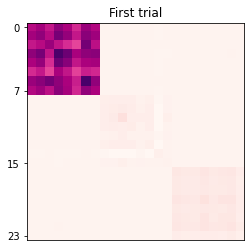

In [92]:
#plot the cov for a given trial
plt.figure()
trial = 0
plt.imshow(cov_ext_trials[trial, :, :], 
           cmap=plt.get_cmap('RdPu'), 
           interpolation='nearest')
plt.xticks([])
_ = plt.yticks([0, 7, 15, 23])
plt.title('First trial')

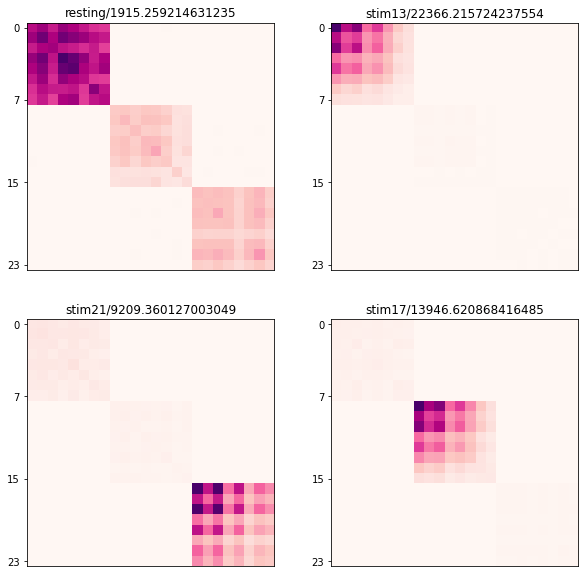

In [132]:
covs = [np.zeros(cov.shape[1:]) for i in range(4)]
samples=[0 for i in range(4)]
for i in range(cov.shape[0]):
    for k in range(4):
        if labels[i]==k:
            covs[k] += cov_ext_trials[i,:,:]
            samples[k]+=1
covs = [covs[k]/samples[k] for k in range(4) ]

fig,axs = plt.subplots(2,2,figsize=(10,10))
axs = axs.flatten()
for k in range(4):
    axs[k].imshow(covs[k], cmap=plt.get_cmap('RdPu'), interpolation='nearest')
    cond =np.linalg.cond(covs[k])
    axs[k].set_title(names[k]+'/'+str(cond))
    axs[k].set_xticks([])
    axs[k].set_yticks([0, 7, 15, 23])
plt.show()

## Classifying extended SSVEP covariance matrices

In [210]:
m= 28 #nb of training samples  
x_train = cov_ext_trials[:m,:,:] 
y_train = labels[:m]
x_test = cov_ext_trials[m:,:,:]
y_test = labels[m:]

In [211]:
y_test

[2, 3, 2, 1]

In [212]:
x_train.shape , x_test.shape

((28, 24, 24), (4, 24, 24))

In [213]:
from pyriemann.utils.mean import mean_riemann
classes = list(range(4))
cov_centers = np.empty((4, 24, 24))
x_trains=[[],[],[],[]]
for i in range(4):
    for j in range(m):
        if labels[j]==i:
            x_trains[i].append(x_train[j,:,:])
for i in range(4):
    x_trains[i]=np.asarray(x_trains[i])

for i in range(4):
    cov_centers[i, :, :] = mean_riemann(x_trains[i])


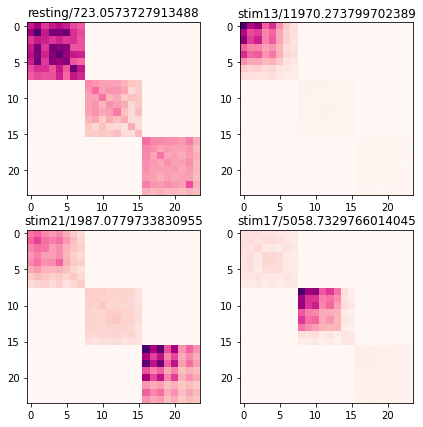

In [214]:
plt.figure(figsize=(7, 7))
for i, l in enumerate(names):
    plt.subplot(2, 2, i+1)
    plt.imshow(cov_centers[i, :, :], cmap=plt.get_cmap('RdPu'), interpolation='nearest')
    cond = np.linalg.cond(cov_centers[i,:,:])
    _ = plt.title(l+'/'+str(cond))

In [215]:
from pyriemann.utils.distance import distance_riemann
classes=list(range(4))
accuracy = list()
for sample, true_label in zip(x_train, y_train):
    dist = [distance_riemann(sample, cov_centers[m]) for m in range(4)]
    if classes[np.array(dist).argmin()] == true_label:
        accuracy.append(1)
    else: accuracy.append(0)
train_accuracy = 100.*np.array(accuracy).sum()/len(y_train)
            
print ('Evaluation accuracy on train set is %.2f%%' % train_accuracy)

Evaluation accuracy on train set is 100.00%


In [216]:
accuracy = list()
for sample, true_label in zip(x_test, y_test):
    dist = [distance_riemann(sample, cov_centers[m]) for m in range(4)]
    if classes[np.array(dist).argmin()] == true_label:
        accuracy.append(1)
    else: accuracy.append(0)
test_accuracy = 100.*np.array(accuracy).sum()/len(y_test)
            
print ('Evaluation accuracy on test set is %.2f%%' % test_accuracy)

Evaluation accuracy on test set is 75.00%
